### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Set random value

In [2]:
ticker = 'AAPL'

In [3]:
tf.random.set_seed(0)

In [4]:
# download the data
df = yf.download(tickers= ticker, period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [5]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [6]:
# generate the input and output sequences
n_lookback = 120  # length of input sequences (lookback period)
n_forecast = 60  # length of output sequences (forecast period)

In [7]:
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

In [8]:
X = np.array(X)

In [9]:
Y = np.array(Y)

In [10]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
3/3 - 3s - loss: 0.1668 - 3s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.1567 - 184ms/epoch - 61ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1433 - 159ms/epoch - 53ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1219 - 139ms/epoch - 46ms/step
Epoch 5/100
3/3 - 0s - loss: 0.1014 - 163ms/epoch - 54ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0827 - 175ms/epoch - 58ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0649 - 138ms/epoch - 46ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0529 - 134ms/epoch - 45ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0451 - 153ms/epoch - 51ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0400 - 143ms/epoch - 48ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0376 - 140ms/epoch - 47ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0359 - 168ms/epoch - 56ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0353 - 134ms/epoch - 45ms/step
Epoch 14/100
3/3 - 0s - loss: 0.0346 - 134ms/epoch - 45ms/step
Epoch 15/100
3/3 - 0s - loss: 0.0345 - 132ms/epoch - 44ms/step
Epoch 16/100
3/3 - 0s - loss: 0.0341 - 137ms/epoch - 46ms/step
Epoch 

In [11]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 851ms/step


In [12]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

<Axes: title={'center': 'AAPL'}, xlabel='Date'>

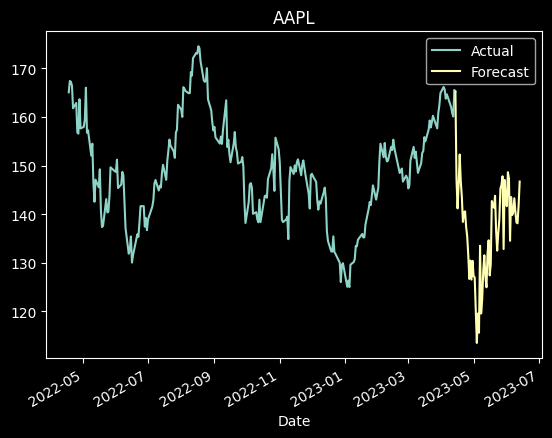

In [13]:
results = pd.concat([df_past, df_future]).set_index("Date")
# plot the results
plt.style.use('dark_background')
results.plot(title=ticker)